In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv

import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

import pymc3 as pm
from pymc3.theanof import set_tt_rng, MRG_RandomStreams 
set_tt_rng(MRG_RandomStreams(42))

from pymc3 import Normal,Metropolis, sample,find_MAP   
import theano.tensor as T
import theano
import lasagne

from scipy.stats import mode, chisquare

import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# read flash.dat to a list of lists
datContent = [i.strip().split() for i in open("DES_full_wavelets.dat").readlines()]
datContent1 = [i.strip().split() for i in open("key.txt").readlines()]
columns=datContent[0]
columns1=datContent1[0]

In [3]:
features = pd.DataFrame(datContent[1:], columns=columns)
features=features.drop(['Object'], axis=1)
features.head()

,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C12,C13,C14,C15,C16,C17,C18,C19,C20,z
0,-25.00037477444413,306.79211490489143,356.8997649727597,36.56806414373808,81.96294271832443,62.84881350054351,-149.50953399302256,49.388635007835,46.425898986402416,9.202334885218706,...,-33.037657156773214,-2.972694976441513,14.275091023477701,43.27783546040833,36.14978526004475,42.272794165931174,34.722632574076236,-1.0936417697512764,-35.21439165696788,0.3502
1,-238.79206891687346,155.3919979441455,211.36807494174155,-3.746101978293055,-93.19830815652585,42.334705719188065,-0.4838348067168141,130.21422038778377,-38.95153007406436,-21.025637471790123,...,73.82622017894873,65.57448246149349,-12.685975243515733,-6.071823311914481,8.494442815914777,-14.946762084511736,21.59773335882574,-11.420969334214146,1.7374948480963388,0.9609
2,-542.521162149438,70.30591950576184,83.55855291754986,-62.43710158940596,-4.303015725470706,13.865165481969552,-10.760797295484963,27.974491688346184,-2.373651075888283,17.846619786960538,...,6.706933251134956,11.655275670677133,5.120015670925272,-12.657090739176272,-3.9683953727566843,-4.338903653156308,16.50174347535103,10.526471774932752,-8.92679194932048,0.5628
3,-209.04457680773876,-121.1521579037945,59.6778141143199,22.282682854904284,-134.8065942940524,-18.231881130250255,-10.396626106209759,31.89273041660975,24.781259200927778,-25.653730436879304,...,10.092535994029824,2.115467645344072,69.00457558938463,28.33006929131822,-22.327955845622725,-14.938633312832923,6.709835775927774,-9.719449198277808,5.925270987983696,0.4747
4,-448.45014262661607,130.38673932244154,-59.986039979245646,60.42144611544627,-38.94952538238488,-29.11613660545993,39.45988907037251,-27.08410046683938,-23.877828822879913,17.637273025995523,...,33.72356414146945,-36.80300636482759,-3.5666978828339744,3.297053642332119,17.83264974893807,-41.45221511454384,-8.489533409627624,14.044875152417134,8.466453914603711,0.8882


In [4]:
labels = pd.DataFrame(datContent1[1:], columns=columns1)
labels.loc[labels['Type']=='3', 'Type']=0
labels.loc[labels['Type']=='2', 'Type']=0
labels.loc[labels['Type']=='1', 'Type']=1
labels=labels.drop(['Object'], axis=1)
labels.head()

,Type
0,0
1,0
2,0
3,0
4,0


In [5]:
X=features.values
Y=labels.values.ravel()
X = X.astype(float)
Y = Y.astype(float)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.25)

In [6]:
scaler = StandardScaler()
scaler.fit(X_train)


X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
%matplotlib inline

def reliability_curve(y_true, y_score, bins=10, normalize=False):

  
    if normalize:  # Normalize scores into bin [0, 1]
        y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())

    bin_width = 1.0 / bins
    bin_centers = np.linspace(0, 1.0 - bin_width, bins) + bin_width / 2

    y_score_bin_mean = np.empty(bins)
    empirical_prob_pos = np.empty(bins)
    for i, threshold in enumerate(bin_centers):
        # determine all samples where y_score falls into the i-th bin
        bin_idx = np.logical_and(threshold - bin_width / 2 < y_score,
                                 y_score <= threshold + bin_width / 2)
        # Store mean y_score and mean empirical probability of positive class
        y_score_bin_mean[i] = y_score[bin_idx].mean()
        empirical_prob_pos[i] = y_true[bin_idx].mean()
    return y_score_bin_mean, empirical_prob_pos

In [9]:
bins=25

reliability_scores = {}
y_score = {}
clf = MLPClassifier(solver='sgd',alpha=1e-5,hidden_layer_sizes=(22,22),random_state=1)


clf.fit(X_train,Y_train)
pred=clf.predict(X_test)


y_score['MLP classifier'] = clf.predict_proba(X_test)[:,1]
reliability_scores['MLP classifier']=\
reliability_curve(Y_test , y_score['MLP classifier'], bins=bins , normalize=False)

/home/tumisang/.local/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


	Accuracy: 0.936
	Precision: 0.876
	Recall: 0.851
	F1: 0.863



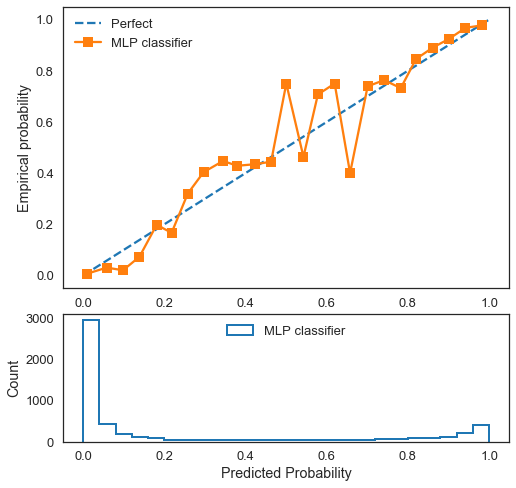

In [31]:
plt.figure(0, figsize=(8, 8))
plt.rcParams.update({'font.size': 18})
plt.subplot2grid((3, 1), (0, 0), rowspan=2)
plt.plot([0.0, 1.0], [0.0, 1.0] ,'--', label="Perfect")
for method, (y_score_bin_mean, empirical_prob_pos) in reliability_scores.items():
    scores_not_nan = np.logical_not(np.isnan(empirical_prob_pos))
    
    plt.errorbar(y_score_bin_mean[scores_not_nan],
             empirical_prob_pos[scores_not_nan] ,fmt='s-',label=method)
plt.ylabel("Empirical probability")
plt.legend(loc=0)

plt.subplot2grid((3, 1), (2, 0))
for method, y_score_ in y_score.items():
    
    y_score_ = (y_score_ - y_score_.min()) / (y_score_.max() - y_score_.min())
    plt.hist(y_score_, range=(0, 1), bins=bins ,label=method,
             histtype="step", lw=2)
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.savefig('reliabilityMLP_SN.png')
plt.legend(loc='upper center', ncol=2)


print("\tAccuracy: %1.3f"%clf.score(X_test, Y_test))
print("\tPrecision: %1.3f" % precision_score(Y_test, pred))
print("\tRecall: %1.3f" % recall_score(Y_test, pred))
print("\tF1: %1.3f\n" % f1_score(Y_test, pred))

In [24]:
clf = MLPClassifier(solver='sgd',alpha=1e-5,hidden_layer_sizes=(22,22),random_state=1)
clf.fit(X_train,Y_train)
Pred_prob_mlp=clf.predict_proba(X_test)
X_true=scaler.inverse_transform(X_test, copy=None)

/home/tumisang/.local/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


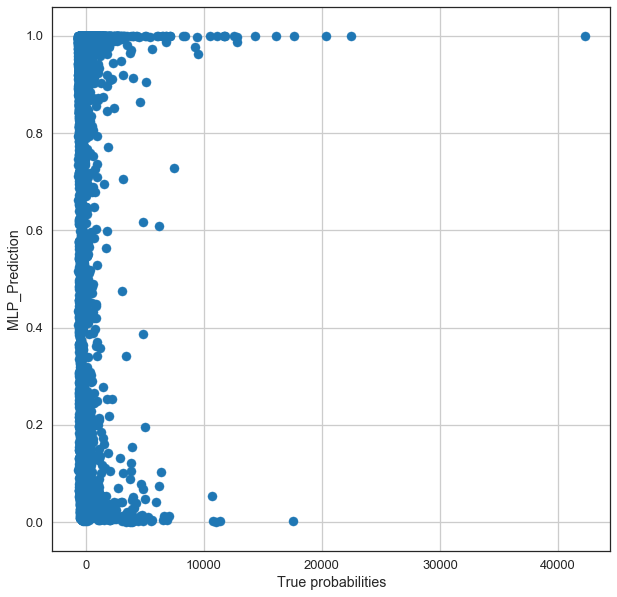

In [30]:
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 18})
plt.scatter(X_true[:,0],Pred_prob_mlp[:,0])
plt.ylabel('MLP_Prediction')
plt.xlabel('True probabilities')
plt.grid()
plt.savefig('true_mlp_supernovae.png')
plt.show()

In [26]:
from sklearn.metrics import confusion_matrix
import itertools

class_names = np.array(['class0','class1'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

 
    plt.tight_layout()

Normalized confusion matrix
[[0.963 0.037]
 [0.149 0.851]]


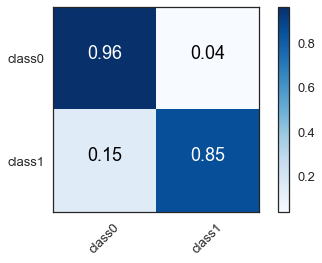

In [27]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, pred)
np.set_printoptions(precision=3)

# Plot non-normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.savefig('confusion_mlp_supernovae.png')
plt.show()

In [1]:
qwe=0